# Random sample of 50 ROIs from NucleusNet-10K.

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

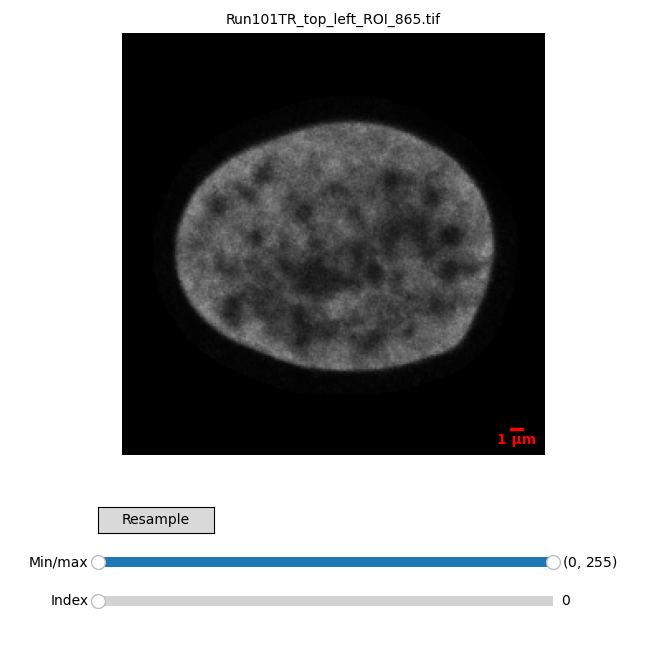

In [1]:
#| label: nucleusnet10k_cellbrowser

%matplotlib widget

import os, logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RangeSlider, Button
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import fsspec
from tifffile import imread as tiff_imread
from urllib.parse import urlparse

# ── Quiet mode: suppress HF/fsspec progress bars & noisy logs ────────────
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["TQDM_DISABLE"] = "1"
try:
    from huggingface_hub.utils import disable_progress_bars
    disable_progress_bars()
except Exception:
    pass
for _name in ("fsspec", "huggingface_hub", "urllib3", "datasets"):
    logging.getLogger(_name).setLevel(logging.ERROR)

# ── Config ───────────────────────────────────────────────────────────────
REPO_ID         = "RussellBarkley/msa-em-figures"
BRANCH          = "main"
HF_GLOBS = [
    f"hf://datasets/{REPO_ID}@{BRANCH}/**/*.tif",
    f"hf://datasets/{REPO_ID}@{BRANCH}/**/*.tiff",
]
K_SAMPLES       = 50
SEED            = None
USE_SIMPLECACHE = True

# Scale bar
PX_PER_UM = 8.0453
SCALER_LENGTH_UM = 1.0

rng = np.random.default_rng(SEED)
fs  = fsspec.filesystem("hf")

def _ensure_hf_uri(p: str) -> str:
    return p if p.startswith("hf://") else ("hf://" + p.lstrip("/"))

def _maybe_cache(uri: str) -> str:
    return f"simplecache::{uri}" if USE_SIMPLECACHE else uri

def _basename_from_uri(uri: str) -> str:
    return os.path.basename(urlparse(uri).path)

def _list_all_tiff_paths():
    paths = []
    for pat in HF_GLOBS:
        try:
            for p in fs.glob(pat):
                paths.append(_ensure_hf_uri(p))
        except Exception:
            pass
    return sorted(set(paths))

ALL_PATHS = _list_all_tiff_paths()
MODE = "files" if len(ALL_PATHS) > 0 else "dataset"

def _load_gray_from_uri(uri: str):
    with fsspec.open(_maybe_cache(uri), "rb") as f:
        arr = tiff_imread(f)
    if arr.ndim == 3:
        arr = arr[..., 0]
    name = _basename_from_uri(uri)
    return name, arr

def _sample_and_load_files(k=K_SAMPLES):
    k = min(k, len(ALL_PATHS))
    idx = rng.choice(len(ALL_PATHS), size=k, replace=False)
    chosen = [ALL_PATHS[i] for i in idx]
    recs = [_load_gray_from_uri(u) for u in chosen]
    recs.sort(key=lambda t: t[0])
    filenames = [r[0] for r in recs]
    images    = [r[1] for r in recs]
    return filenames, images

def _sample_and_load_dataset(k=K_SAMPLES):
    from datasets import load_dataset
    ds = load_dataset(REPO_ID, split="train", keep_in_memory=False)
    k = min(k, len(ds))
    idx = rng.choice(len(ds), size=k, replace=False)
    subset = ds.select(sorted(idx.tolist()))
    filenames, images = [], []
    for ex in subset:
        arr = np.asarray(ex["image"])
        if arr.ndim == 3:
            arr = arr[..., 0]
        name = ex.get("filename", f"sample_{len(filenames):05d}.tif")
        filenames.append(name)
        images.append(arr)
    return filenames, images

def _sample_and_load(k=K_SAMPLES):
    return _sample_and_load_files(k) if MODE == "files" else _sample_and_load_dataset(k)

# ── Initial load (random 50) ─────────────────────────────────────────────
filenames, images = _sample_and_load()
if len(images) == 0:
    raise RuntimeError("No images found in repo/dataset.")
n = len(images)

# ── Viewer ──────────────────────────────────────────────────────────────
img0 = images[0]
if np.issubdtype(img0.dtype, np.integer):
    lo0, hi0 = 0, int(np.iinfo(img0.dtype).max)
else:
    lo0, hi0 = float(np.nanmin(img0)), float(np.nanmax(img0))
if not np.isfinite(lo0): lo0 = 0.0
if not np.isfinite(hi0): hi0 = lo0 + 1.0
if hi0 <= lo0: hi0 = lo0 + 1.0

fig, ax = plt.subplots(figsize=(6.5, 6.5))
plt.subplots_adjust(bottom=0.30, top=0.95)

im = ax.imshow(img0, cmap='gray', vmin=lo0, vmax=hi0)
ax.set_axis_off()
title = ax.set_title(filenames[0], fontsize=10)  # ← repo name removed

# Scalebar
bar_px = SCALER_LENGTH_UM * PX_PER_UM
fontprops = fm.FontProperties(size=10, weight='bold')
scalebar = AnchoredSizeBar(
    ax.transData, bar_px, f"{SCALER_LENGTH_UM:g} μm",
    loc='lower right', pad=0.5, color='red',
    frameon=False, size_vertical=1, fontproperties=fontprops
)
ax.add_artist(scalebar)

# Contrast slider
contrast_ax = fig.add_axes([0.15, 0.12, 0.70, 0.03])
step = max(1, int((hi0 - lo0) // 1024)) if np.issubdtype(img0.dtype, np.integer) else None
contrast_slider = RangeSlider(
    ax=contrast_ax, label='Min/max',
    valmin=float(lo0), valmax=float(hi0),
    valinit=(float(lo0), float(hi0)), valstep=step,
)
def update_contrast(_):
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    fig.canvas.draw_idle()
contrast_slider.on_changed(update_contrast)

# Index slider
idx_ax = fig.add_axes([0.15, 0.06, 0.70, 0.03])
idx_slider = Slider(ax=idx_ax, label='Index', valmin=0, valmax=n-1, valinit=0, valstep=1, valfmt='%0.0f')

def update_image(_):
    idx = int(idx_slider.val)
    im.set_data(images[idx])
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    title.set_text(filenames[idx])  # ← repo name removed
    fig.canvas.draw_idle()
idx_slider.on_changed(update_image)

# Resample (new random 50)
btn_ax = fig.add_axes([0.15, 0.18, 0.18, 0.04])
resample_btn = Button(btn_ax, "Resample")
def on_resample(event=None):
    global filenames, images, n
    filenames, images = _sample_and_load()
    n = len(images)
    idx_slider.valmax = n - 1
    idx_slider.set_val(0)
    im.set_data(images[0])
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    title.set_text(filenames[0])  # ← repo name removed
    fig.canvas.draw_idle()
resample_btn.on_clicked(on_resample)

# Toolbar back/forward → prev/next index
tb = getattr(fig.canvas, "toolbar", None)
if tb is not None:
    def _back_override(*args, **kwargs):
        cur = int(idx_slider.val)
        if cur > 0:
            idx_slider.set_val(cur - 1)
    def _forward_override(*args, **kwargs):
        cur = int(idx_slider.val)
        if cur < n - 1:
            idx_slider.set_val(cur + 1)
    tb.back = _back_override
    tb.forward = _forward_override
